# Get Leaderboard predictions

## Setup

### Import libraries

In [1]:
import datetime
from datetime import timedelta
from os.path import join
import time

import datarobot as dr
import helper
import matplotlib
import numpy as np
import pandas as pd

###Get and prepare ata

Run the data through a similar process that was used for the training data.

In [2]:
data = pd.read_csv(
    "https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/trading_activity/stock_data.csv"
)

In [3]:
data = data[
    [
        "date",
        "date_time",
        "Symbol",
        "minute",
        "TradeVolume",
        "TradePrice",
        "NumTrades",
        "Sector",
        "Security_Type",
        "Cap",
        "Style",
        "Exchange",
    ]
].copy()

In [4]:
end = data.date.max()

In [5]:
# Number of minutes in each window
window_length = 1
# How many windows to look ahead and behind
neighbours_radius = 1
# Use percentage of volume
percentage = True

modelling_choice = {
    "window_length": window_length,
    "window_radius": neighbours_radius,
    "percentage": percentage,
}

In [6]:
prediction_data = helper.prepare_data_for_predictions(
    data, modelling_choice, aggregation_dictionary=modelling_choice
)

In [7]:
time_cut = timedelta(hours=15, minutes=30)

In [8]:
prediction_data = prediction_data[prediction_data.minute_min > time_cut]

In [9]:
prediction_data.columns

Index(['date_time_', 'Symbol_', 'Sector_', 'Security_Type_', 'Cap_', 'Style_',
       'Exchange_', 'date_first', 'minute_min', 'TradeVolume_min',
       'TradeVolume_max', 'TradeVolume_std', 'TradePrice_mean',
       'TradePrice_min', 'TradePrice_max', 'TradePrice_std', 'NumTrades_sum',
       'NumTrades_min', 'NumTrades_max', 'NumTrades_std', 'TradeVolume_sum',
       'TradeVolume_min_fwd_1', 'TradeVolume_max_fwd_1',
       'TradeVolume_std_fwd_1', 'TradePrice_mean_fwd_1',
       'TradePrice_min_fwd_1', 'TradePrice_max_fwd_1', 'TradePrice_std_fwd_1',
       'NumTrades_sum_fwd_1', 'NumTrades_min_fwd_1', 'NumTrades_max_fwd_1',
       'NumTrades_std_fwd_1', 'TradeVolume_sum_fwd_1', 'TradeVolume_min_bwd_1',
       'TradeVolume_max_bwd_1', 'TradeVolume_std_bwd_1',
       'TradePrice_mean_bwd_1', 'TradePrice_min_bwd_1', 'TradePrice_max_bwd_1',
       'TradePrice_std_bwd_1', 'NumTrades_sum_bwd_1', 'NumTrades_min_bwd_1',
       'NumTrades_max_bwd_1', 'NumTrades_std_bwd_1', 'TradeVolume_sum_bw

In [10]:
prediction_data[
    [
        "date_first",
        "date_time_",
        "Symbol_",
        "minute_min",
        "TradeVolume_sum",
        "Sector_",
        "Security_Type_",
        "Cap_",
        "Style_",
        "Exchange_",
    ]
].tail()

,date_first,date_time_,Symbol_,minute_min,TradeVolume_sum,Sector_,Security_Type_,Cap_,Style_,Exchange_
148565,2018-06-08,2018-06-08 15:55:00,WMT,0 days 15:55:00,,Retail,Common Stock,Large,Value,NYSE
148566,2018-06-08,2018-06-08 15:56:00,WMT,0 days 15:56:00,,Retail,Common Stock,Large,Value,NYSE
148567,2018-06-08,2018-06-08 15:57:00,WMT,0 days 15:57:00,,Retail,Common Stock,Large,Value,NYSE
148568,2018-06-08,2018-06-08 15:58:00,WMT,0 days 15:58:00,,Retail,Common Stock,Large,Value,NYSE
148569,2018-06-08,2018-06-08 15:59:00,WMT,0 days 15:59:00,,Retail,Common Stock,Large,Value,NYSE


Note that the rows for which you want predictions need to have all the known in advance features, but not the value to predict.

### Retrieve relevant projects

In [11]:
projects_df = pd.read_pickle(
    "results/VolPred_percentage_each_1min_v_2022-11-14-23-12-28.pkl"
)

In [12]:
projects_df.head()

,project_id,slice,url,project,deployment_id,MASE,model
0,6372796b52dd086a82a4337c,15:31,https://app.datarobot.com/projects/6372796b52d...,Project(VolPred_percentage_each_1min_15:31_v_2...,6372cd615a87f42014e78ea4,0.77930,63727b232bfd63533d45ffb5
1,63727a1552dd086a82a43383,15:32,https://app.datarobot.com/projects/63727a1552d...,Project(VolPred_percentage_each_1min_15:32_v_2...,6372cd669221ba89ab1c2080,0.75075,63727bc1fdd002317cba0f19
2,63727abc9ae8e86e8b8942e4,15:33,https://app.datarobot.com/projects/63727abc9ae...,Project(VolPred_percentage_each_1min_15:33_v_2...,6372cd6b5a87f42014e78ebe,0.73442,63727c9d98110b63f2cc1e55
3,63727b6b9ae8e86e8b8942ff,15:34,https://app.datarobot.com/projects/63727b6b9ae...,Project(VolPred_percentage_each_1min_15:34_v_2...,6372cd701791a5dc46e78c82,0.87725,63727d3117b183a9a051832f
4,63727c1b2331f284bfa432cd,15:35,https://app.datarobot.com/projects/63727c1b233...,Project(VolPred_percentage_each_1min_15:35_v_2...,6372cd7529a7a77a961c2233,0.88611,63727dea9615530786f73ec4


### Connect to DataRobot

In [13]:
# Instantiate the DataRobot connection

DATAROBOT_API_TOKEN = ""  # Get this from the Developer Tools page in the DataRobot UI
# Endpoint - This notebook uses the default endpoint for DataRobot Managed AI Cloud (US)
DATAROBOT_ENDPOINT = "https://app.datarobot.com/api/v2"  # This should be the URL you use to access the DataRobot UI

client = dr.Client(
    token=DATAROBOT_API_TOKEN,
    endpoint=DATAROBOT_ENDPOINT,
    user_agent_suffix="",  # Optional but helps DataRobot improve this workflow
)

dr.client._global_client = client

In [14]:
delta = timedelta(
    hours=int(projects_df.slice[0].split(":")[0]),
    minutes=int(projects_df.slice[0].split(":")[1]),
)
filtered_data = prediction_data[prediction_data.minute_min == delta]

In [15]:
filtered_data.TradeVolume_sum.replace("", 0).sum()

0.3138308114004962

## Get predictions from top models

In [16]:
results = []

for i, row in projects_df.iterrows():
    # print(str(i) + '-th job')
    # load project and get recommended model
    project = dr.Project.get(row.project_id)
    recommended_model = project.recommended_model()

    # convert the time to timedelta so we can use it to filer the dataset
    delta = timedelta(
        hours=int(row.slice.split(":")[0]), minutes=int(row.slice.split(":")[1])
    )
    filtered_data = prediction_data[prediction_data.minute_min == delta]

    # Upload the resulting data and score it
    prediction_dataset = project.upload_dataset(filtered_data)
    predict_job = recommended_model.request_predictions(prediction_dataset.id)

    result = predict_job.get_result_when_complete()
    results.append(result)

### Compare predictions to actuals

In [17]:
next_day_predictions = (
    pd.concat(results).reset_index().drop(columns=["index", "row_id"])
)

In [18]:
next_day_predictions.sort_values(["series_id", "timestamp"], inplace=True)

In [19]:
next_day_predictions.head(5)

,prediction,forecast_distance,forecast_point,timestamp,series_id
0,0.001803,1,2018-06-07T15:31:00.000000Z,2018-06-08T15:31:00.000000Z,AAPL
10,0.002456,1,2018-06-07T15:32:00.000000Z,2018-06-08T15:32:00.000000Z,AAPL
20,0.001904,1,2018-06-07T15:33:00.000000Z,2018-06-08T15:33:00.000000Z,AAPL
30,0.002101,1,2018-06-07T15:34:00.000000Z,2018-06-08T15:34:00.000000Z,AAPL
40,0.003055,1,2018-06-07T15:35:00.000000Z,2018-06-08T15:35:00.000000Z,AAPL


In [20]:
next_day_actuals = pd.read_csv(
    "https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/trading_activity/data_for_comparison_30min.csv"
)

In [21]:
next_day_actuals.sort_values(["Symbol_", "date_time_"], inplace=True)

In [22]:
next_day_actuals.date_time_ = pd.to_datetime(next_day_actuals.date_time_).dt.strftime(
    "%m/%d/%Y, %H:%M:%S"
)

In [23]:
next_day_predictions.timestamp = pd.to_datetime(
    next_day_predictions.timestamp
).dt.strftime("%m/%d/%Y, %H:%M:%S")

In [24]:
df_join = pd.merge(
    next_day_predictions,
    next_day_actuals,
    left_on=["timestamp", "series_id"],
    right_on=["date_time_", "Symbol_"],
    how="left",
)

In [25]:
df_join.columns

Index(['prediction', 'forecast_distance', 'forecast_point', 'timestamp',
       'series_id', 'Symbol_', 'date_time_', 'TradeVolume_sum'],
      dtype='object')

In [26]:
df_join = df_join[["prediction", "timestamp", "Symbol_", "TradeVolume_sum"]]

## Choose a symbol to plot

In [27]:
df_join.Symbol_.unique()

array(['AAPL', 'AMZN', 'DIS', 'F', 'FB', 'NFLX', 'QQQ', 'SPY', 'VZ',
       'WMT'], dtype=object)

In [28]:
symbol = "AAPL"

In [29]:
df = df_join[df_join.Symbol_ == symbol]

<Axes: xlabel='timestamp'>

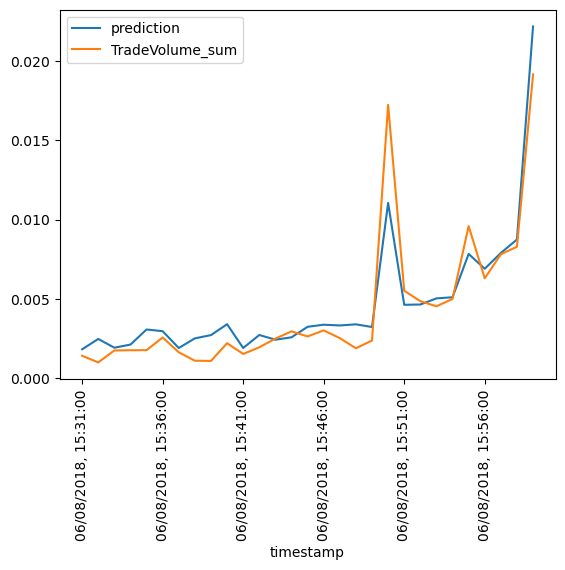

In [30]:
df.plot(x="timestamp", y=["prediction", "TradeVolume_sum"], rot=90)